In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import t
import seaborn as sns
import pandas as pd 
import numpy as np
import random
import time

#Numerical SIR model

In [ ]:
gamma = 1/14
beta = 0.2
N = 10000
I_0 = 1
S_0 = N-1
R_0 = 0

R0 = beta/gamma
print(f"\u03B3 = {gamma}")
print(f"\u03B2 = {beta}")
print(f"R0 = {R0}")
print(f'N = {N}')

γ = 0.07142857142857142
β = 0.2
R0 = 2.8000000000000003
N = 10000


In [ ]:
def S_func(beta, N, S_p, I_p):
  return S_p - ((beta/N)*S_p*I_p)

def I_func(beta, N, gamma, S_p, I_p):
  return I_p + ((beta/N)*S_p*I_p) - (gamma*I_p)

def R_func(gamma, I_p, R_p):
  return R_p + (gamma*I_p)

In [ ]:
#Value at time t-1 
S_p = S_0 
I_p = I_0
R_p = R_0
#all the value
S_t = []
I_t = []
R_t = []
for i in range(365):
  #new value
  S_n = S_func(beta, N, S_p, I_p)
  I_n = I_func(beta, N, gamma, S_p, I_p)
  R_n = R_func(gamma, I_p, R_p)
  #update the previous value
  I_p = I_n 
  S_p = S_n 
  R_p = R_n
  S_t.append(S_n)
  I_t.append(I_n)
  R_t.append(R_n)

In [ ]:
I_max = np.max(I_t)
I_max_day = np.argmax(I_t)+1
print(f"The max number of infected people is: {I_max}")
print(f"It is reached after {I_max_day} days")

The max number of infected people is: 2823.4299756346727
It is reached after 80 days


In [ ]:
print(f'The susceptible people remained in the population are: {np.min(S_t)}')
print(f'The total number of recovered People: {np.max(R_t)}')

The susceptible people remained in the population are: 704.8873841706693
The total number of recovered People: 9295.112295332334


In [ ]:
p = 1-(1/R0)
print(f"The portion of the population needed to establish the herb immunity is {p*100}%")
N_imm = p*N
print(f'The number of people to reach the herd immunity is: {N_imm}')

The portion of the population needed to establish the herb immunity is 64.28571428571429%
The number of people to reach the herd immunity is: 6428.571428571429


In [ ]:
def find_herd_immunity(R_t, N_imm):
  d_end = 0
  for i in range(len(R_t)):
    if R_t[i]> N_imm:
      d_end = i+1
      break

  #if is not reached -> the day of the last recover
  if d_end == 0: 
    d_end = np.argmax(R_t)+1

  return d_end

d_end = find_herd_immunity(R_t, N_imm)
print(f'The epidemic end after {d_end} days')

The epidemic end after 96 days


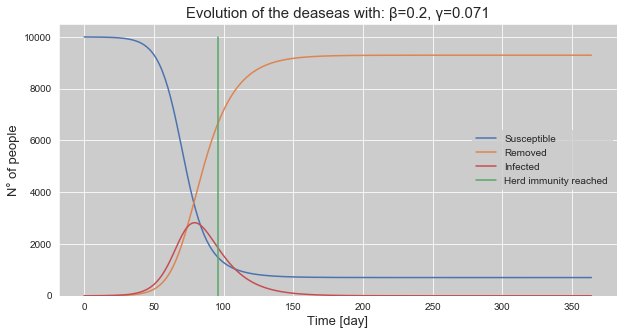

In [ ]:
pal = sns.color_palette("deep")
pal.as_hex()
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(range(365), S_t, label='Susceptible', color= pal[0]) 
ax.plot(range(365), R_t, label='Removed', color=pal[1]) 
ax.plot(range(365), I_t, label='Infected', color = pal[3]) 
ax.plot([d_end, d_end], [0, N], label = "Herd immunity reached", color = pal[2])

ax.set_ylim(ymin=0)
ax.set_xlabel("Time [day]", fontsize=13)
ax.set_ylabel("N° of people", fontsize=13) 
ax.legend()
plt.title(f"Evolution of the deaseas with: \u03B2={round(beta,2)}, \u03B3={round(gamma,3)}", fontsize=15)
plt.show()

#Simulative SIR model

In [ ]:
def conf_int(vect, cl, N_runs):
  mean = np.mean(vect)
  var = np.var(vect, ddof=1)
  if var == 0:
    ci = (mean, mean)
  else:
    ci = t.interval(cl, N_runs-1, mean, np.sqrt(var/N_runs))

  return ci, mean

In [ ]:
def compute_Rt(Environment):
  people = Environment.get_people()
  Rt = []

  for day in range(365):
    tot_i = 0
    tot_p = 0 
    for p in people:
      if (day >= p.get_day_start()) and (day <= p.get_day_end()):
        tot_i += p.get_N_infected()
        tot_p += 1
        p.decrese_N_infected(day) #remove the past history
        
    if tot_p == 0: #no one is infected
      Rt.append(0) # Rt is 0
    else: 
      Rt.append(tot_i/tot_p)

  return Rt

## Data structure

In [ ]:
#state == 0 -> susceptible
#state == 1 -> Infected
#state == 2 -> removed

class Person:
  def __init__(self, id, gamma):
    self.id = id
    self.state = 0  #the actual state of the person
    self.day_start = -1 #it's the day on which it becomes infected
    self.day_end = -1  #it's the day of the recover
    self.time = 0   #days passed since the infection
    self.N_infected = 0   #number of people infected by this person
    self.gamma = gamma    #it's the recovery rate for this person
    self.N_contact = 0    #number of contact with other people
    self.day_infection = []  #day at which infect another people

  def get_ID(self):
    return self.id

  def get_state(self,day):
    if (self.state == 1) and (self.day_start == day): #is the day on which he become infected
      return -1
    else:
      return self.state
  
  def get_day_start(self):
    return self.day_start

  def get_day_end(self):
    return self.day_end

  def get_time(self):
    return self.time
  
  def increase_N_infected(self, day):
    self.N_infected += 1  #infected a new person
    self.day_infection.append(day)   #day of the infection
    return

  def get_N_infected(self):
    return self.N_infected

  def increase_N_contact(self):
    self.N_contact += 1
    return

  def decrese_N_infected(self, day):
    for d in self.day_infection: 
      if d == day: #remouve the past history
        self.N_infected -= 1 
    return

  def get_N_contact(self):
    return self.N_contact

  def become_infected(self, day):
    self.state = 1
    self.day_start = day

  def recover(self, day):
    if self.state != 1:  #is not infected
      return False 
    
    if self.day_start == day:  #new infected, can not recover on the same day of the infection
      return False

    P_rec = random.uniform(0,1)
    if P_rec <= self.gamma: 
      self.state = 2
      self.day_end = day
      self.time = self.day_end - self.day_start
      return True
    else:
      return False

In [ ]:
class Environment():
  def __init__(self, N=0, beta=0, gamma=0):
    if (N <= 1) or (beta <= 0) or (gamma <= 0):
      print('Wrong parameters!')
      return 

    self.N = N   #number of people
    self.people = []  #vector of person
    for i in range(self.N):
      self.people.append(Person(i, gamma)) #all with the same recovery rate
    self.beta = beta 

    i = random.randint(0, self.N-1)      #first infected
    self.day = 0
    self.people[i].become_infected(self.day)
    self.R = 0
    self.I = 1
    self.S = self.N-1

  def infect(self):
    for i in range(self.N):   #the person i ...
      N_meet = np.random.poisson(lam=self.beta)  #how many people meet
      if N_meet > 0:
        id_meet = random.sample(range(N), N_meet) #who are those people
        while i in id_meet: #can not meet himself
          id_meet = random.sample(range(N), N_meet)

        for j in id_meet:
          state_i = self.people[i].get_state(self.day)
          state_j = self.people[j].get_state(self.day)
          self.people[i].increase_N_contact()   #for debug 
          self.people[j].increase_N_contact()   #for debug
          if state_i == 1 and state_j == 0:
            self.people[j].become_infected(self.day)   #become infected
            self.S -= 1             #update susceptible
            self.I += 1             #update infected
            self.people[i].increase_N_infected(self.day)
          elif state_j == 1 and state_i == 0:
            self.people[i].become_infected(self.day)   #become infected
            self.S -= 1             #update susceptible
            self.I += 1             #update infected
            self.people[j].increase_N_infected(self.day)
    return

  def recover(self):
    for i in range(self.N):
      if self.people[i].recover(self.day):  #can recover
        self.R += 1
        self.I -= 1
    return

  def next_day(self):
    self.day += 1
    return

  def get_people(self):
    return self.people

  def get_SIR(self):
    return self.S, self.I, self.R

##Simulation

In [ ]:
def Simulate(days, N,N_imm, beta, gamma):
  environment = Environment(N, beta, gamma)
  I_t = []
  R_t = []
  for _ in range(days):
    environment.infect()
    environment.recover()
    environment.next_day()
    _ , I, R = environment.get_SIR()
    I_t.append(I)
    R_t.append(R)
    
  i_max = np.max(I_t)
  day_max = np.argmax(I_t)+1 
  day_end = find_herd_immunity(R_t, N_imm)
  Rt = compute_Rt(environment)
  return i_max, day_max, day_end, Rt

In [ ]:
#input parameters
N_runs = 30
cl = 0.95
seed = 0

N = 10000
N_imm = 6428 
beta = 0.1
gamma = 1/14
days = 365

print(f"The population size is: {N}")
print(f"Number of immune people needed for the herd immunity: {N_imm}")
print(f"\u03B2 = {beta}")
print(f"\u03B3 = {gamma}")

The population size is: 10000
Number of immune people needed for the herd immunity: 6428
β = 0.1
γ = 0.07142857142857142


In [ ]:
#output metrics
I_max = []
I_max_day = []
Days_end = []
RT = []

In [ ]:
#simulation
for r in range(N_runs):
  print(f"Run: {r}")
  np.random.seed(seed)
  random.seed(seed)
  i_max, day_max, day_end, Rt = Simulate(days, N, N_imm, beta, gamma)
  I_max.append(i_max)
  I_max_day.append(day_max)
  Days_end.append(day_end)
  RT.append(Rt)
  seed += 1

Run: 0
Run: 1
Run: 2
Run: 3
Run: 4
Run: 5
Run: 6
Run: 7
Run: 8
Run: 9
Run: 10
Run: 11
Run: 12
Run: 13
Run: 14
Run: 15
Run: 16
Run: 17
Run: 18
Run: 19
Run: 20
Run: 21
Run: 22
Run: 23
Run: 24
Run: 25
Run: 26
Run: 27
Run: 28
Run: 29


In [ ]:
ci_max, mean_max = conf_int(I_max, cl, len(I_max))
ci_max_day, mean_max_day = conf_int(I_max_day, cl, len(I_max_day)) 
ci_end, mean_end = conf_int(Days_end, cl, len(Days_end)) 

print("With degenerative runs:")
print(f'The maximum number of infected people is {mean_max}')
print(f'With the confidence interval: {ci_max}')
print(f'The maximum number of infected people is reached after {mean_max_day} day')
print(f'With the confidence interval: {ci_max_day}')
print(f'The epidemics end after {mean_end} days')
print(f'With the confidence interval: {ci_end}')

With degenerative runs:
The maximum number of infected people is 2208.5666666666666
With the confidence interval: (1788.5342649820625, 2628.5990683512705)
The maximum number of infected people is reached after 66.56666666666666 day
With the confidence interval: (53.77777826159724, 79.35555507173608)
The epidemics end after 80.3 days
With the confidence interval: (65.6120245231541, 94.98797547684589)


In [ ]:
#remove the degenerative runs
deg_runs = 0
for i in reversed(range(N_runs)): 
  if I_max[i] < 50:
    I_max.pop(i)
    I_max_day.pop(i)
    Days_end.pop(i)
    RT.pop(i)
    deg_runs += 1

ci_max, mean_max = conf_int(I_max, cl, len(I_max))
ci_max_day, mean_max_day = conf_int(I_max_day, cl, len(I_max_day)) 
ci_end, mean_end = conf_int(Days_end, cl, len(Days_end)) 
print(f"Removed {deg_runs} degenerative runs")
print("Without degenerative runs:")
print(f'The maximum number of infected people is {mean_max}')
print(f'With the confidence interval: {ci_max}')
print(f'The maximum number of infected people is reached after {mean_max_day} day')
print(f'With the confidence interval: {ci_max_day}')
print(f'The epidemics end after {mean_end} days')
print(f'With the confidence interval: {ci_end}')

Removed 6 degenerative runs
Without degenerative runs:
The maximum number of infected people is 2760.4166666666665
With the confidence interval: (2726.3313372987577, 2794.5019960345753)
The maximum number of infected people is reached after 82.83333333333333 day
With the confidence interval: (78.65005343432075, 87.0166132323459)
The epidemics end after 99.125 days
With the confidence interval: (94.99835568717684, 103.25164431282316)


In [ ]:
#one single istance of the simulation
np.random.seed(0)
random.seed(0)
environment = Environment(N, 0.1, 1/14)
S_t = []
I_t = []
R_t = []
for j in range(365):
  environment.infect()
  environment.recover()
  environment.next_day()
  S_n, I_n, R_n = environment.get_SIR()
  S_t.append(S_n)
  I_t.append(I_n)
  R_t.append(R_n)

print(f"Max infected: {np.max(I_t)}")
print(f"Day max: {np.argmax(I_t)+1}")
day_end = find_herd_immunity(R_t, N_imm)
print(f"Day end = {day_end}")

Max infected: 2838
Day max: 79
Day end = 96


##Plotting

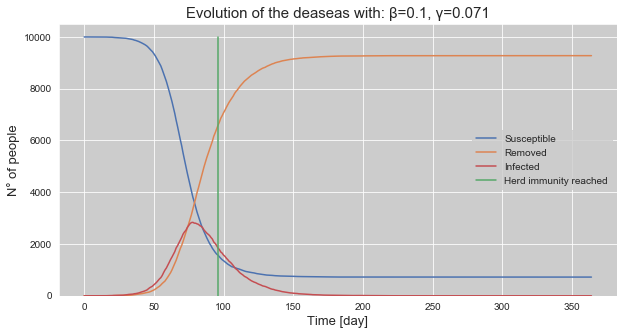

In [ ]:
#plotting S(t), I(t) and R(t)
pal = sns.color_palette("deep")
pal.as_hex()
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(range(365), S_t, label='Susceptible', color= pal[0]) 
ax.plot(range(365), R_t, label='Removed', color=pal[1]) 
ax.plot(range(365), I_t, label='Infected', color = pal[3]) 
ax.plot([day_end, day_end], [0, N], label = "Herd immunity reached", color = pal[2])

ax.set_ylim(ymin=0)
ax.set_xlabel("Time [day]", fontsize=13)
ax.set_ylabel("N° of people", fontsize=13) 
ax.legend()
plt.title(f"Evolution of the deaseas with: \u03B2={round(beta,2)}, \u03B3={round(gamma,3)}", fontsize=15)
plt.show()

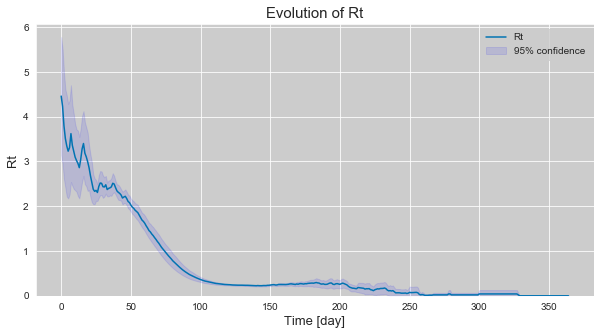

In [ ]:
#plotting Rt + confidence interval
sns.set_palette("colorblind")  
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})
fig, ax = plt.subplots(figsize=(10,5))

RT = np.array(RT)
Mean_rt = []
CI_rt = []
for i in range(365):
  ci_rt, m_rt = conf_int(RT[:,i], cl, len(RT))
  Mean_rt.append(m_rt)
  CI_rt.append(ci_rt)

LW_ci = []
UP_ci = []
for i in range(len(CI_rt)):
  LW_ci.append(CI_rt[i][0])
  UP_ci.append(CI_rt[i][1])

ax.plot(range(365), Mean_rt, label='Rt') 
ax.fill_between(range(365), LW_ci, UP_ci, color='b', alpha=.1, label="95% confidence")
ax.set_ylim(ymin=0)
ax.set_xlabel("Time [day]", fontsize=13)
ax.set_ylabel("Rt", fontsize=13) 
ax.legend()
plt.title("Evolution of Rt", fontsize=15)
plt.show()

#Extension of SIR model

##Data structure

In [ ]:
#state == 0 -> susceptible
#state == 1 -> Infected
#state == 2 -> removed

class Person:
  def __init__(self, id, gamma):
    self.id = id
    self.state = 0  #the actual state of the person
    self.day_start = -1 #it's the day on which it becomes infected
    self.day_end = -1  #it's the day of the recover
    self.time = 0   #days passed since the infection
    self.N_infected = 0   #number of people infected by this person
    self.gamma = gamma    #it's the recovery rate for this person
    self.N_contact = 0    #number of contact with other people
    self.day_infection = []  #day at which infect another people

  def get_ID(self):
    return self.id

  def get_state(self,day):
    if (self.state == 1) and (self.day_start == day): #is the day on which he become infected
      return -1
    else:
      return self.state
  
  def get_day_start(self):
    return self.day_start

  def get_day_end(self):
    return self.day_end

  def get_time(self):
    return self.time
  
  def increase_N_infected(self, day):
    self.N_infected += 1  #infected a new person
    self.day_infection.append(day)   #day of the infection
    return

  def get_N_infected(self):
    return self.N_infected

  def increase_N_contact(self):
    self.N_contact += 1
    return

  def decrese_N_infected(self, day):
    for d in self.day_infection:
      if d == day:
        self.N_infected -= 1 
    return

  def get_N_contact(self):
    return self.N_contact

  def become_infected(self, day):
    self.state = 1
    self.day_start = day

  def recover(self, day):
    if self.state != 1:  #is not infected
      return False 
     #new infected, can not recover on the same day of the infection
    if self.day_start == day: 
      return False

    P_rec = random.uniform(0,1)
    if P_rec <= self.gamma:
      self.state = 2
      self.day_end = day
      self.time = self.day_end - self.day_start
      return True
    else:
      return False

In [ ]:
class Location():
  def __init__(self, id = -1, beta=0):
    if id == -1:
      print("miss the id of the location")
    if beta < 0:
      print(f"Wrong parameter in the location {id}")
    self.people_index = []   #index of the people in this location
    self.id_location = id  
    self.beta = beta

  def add_person(self, index): #add a people into this location
    self.people_index.append(index)
    return

  def empty(self):  #remove all the people
    self.people_index = []
    return

  def set_beta(self, new_beta):
    self.beta = new_beta
    return
    
  def meet(self):
    meeting = []
    if len(self.people_index) <= 1:
      return meeting

    for i in self.people_index:
      N_meet = np.random.poisson(lam=self.beta)  #how many people meet
      if N_meet > 0:
        id_meet = random.sample(self.people_index, N_meet) #who are those people
        while i in id_meet: #can not meet himself
          id_meet = random.sample(self.people_index, N_meet)
        for j in id_meet:
          meeting.append((i,j))

    return meeting

In [ ]:
class Environment():
  def __init__(self, N=0, beta=[], gamma=[], N_locations=0, P_out=0):
    if (N <= 0) or (len(beta)<= 0) or (len(gamma)==0) or (N_locations<=0) or (P_out<0):
      print('Wrong or missing parameters!')
      return 
    if len(beta) != N_locations:
      print('Error: wrong length of beta')
      return

    self.N = N
    self.people = []
    for i in range(self.N):
      P_cat = random.uniform(0,1)  #uniform distribution
      for g in range(len(gamma)):     
        if P_cat <= ((g+1)/len(gamma)):
          self.people.append(Person(i, gamma[g]))

    self.P_out = P_out
    self.N_loc = N_locations
    self.locations = []  #init locations
    for j in range(self.N_loc):
      self.locations.append(Location(j, beta[j])) #each location has its own beta

    #first case
    i = random.randint(0, self.N-1)
    self.day = 0
    self.people[i].become_infected(self.day) 
    self.R = 0
    self.I = 1
    self.S = self.N-1

  def move(self):
    for loc in self.locations: #remove all the people from the location
      loc.empty()
      
    for i in range(N): #for all the people
      out = random.uniform(0,1) #are the person go out?
      if out <= self.P_out:
        i_loc = random.randint(0, self.N_loc-1) #if yes-> go to the location i_loc
        self.locations[i_loc].add_person(i)
    return

  def infect(self):
    for loc in self.locations:
      contact = loc.meet()  #all the contact that occurring in that location
      for i,j in contact:
        state_i = self.people[i].get_state(self.day)
        state_j = self.people[j].get_state(self.day)
        self.people[i].increase_N_contact()   #for debugging
        self.people[j].increase_N_contact()
        if state_i == 1 and state_j == 0:
          self.people[j].become_infected(self.day)   #j become infected
          self.S -= 1             #update susceptible
          self.I += 1             #update infected
          self.people[i].increase_N_infected(self.day)
        elif state_j == 1 and state_i == 0:
          self.people[i].become_infected(self.day)   #i become infected
          self.S -= 1             #update susceptible
          self.I += 1             #update infected
          self.people[j].increase_N_infected(self.day)
  
  def recover(self):
    for i in range(self.N):
      if self.people[i].recover(self.day):  #can recover
        self.R += 1
        self.I -= 1
    return

  def next_day(self):
    self.day += 1
    # self.contact = []
    return

  def set_restriction(self, new_beta=[], new_P_out = 0):
    if new_P_out != 0 and new_P_out > 0:
      self.P_out = new_P_out  #coprifuoco

    if len(new_beta) != self.N_loc:
      # print('Wrong length for new_beta!')
      return

    for i in range(len(new_beta)):
      self.locations[i].set_beta(new_beta[i])

    return

  def get_SIR(self):
    return self.S, self.I, self.R

  def get_people(self):
    return self.people

##Simulation

In [ ]:
def Simulate(days, N, beta, gamma, N_location, P_out):
  environment = Environment(N, beta, gamma, N_location, P_out)
  I_t = []
  R_t = []
  N_imm = 6428
  for _ in range(days):
    environment.move()
    environment.infect()
    environment.recover()
    environment.next_day()
    _ , I, R = environment.get_SIR()
    I_t.append(I)
    R_t.append(R)
    
  i_max = np.max(I_t)
  day_max = np.argmax(I_t)+1 
  day_end = find_herd_immunity(R_t, N_imm)
  Rt = compute_Rt(environment)
  return i_max, day_max, day_end, Rt

###Case 0

In [ ]:
#input variable
N_runs = 30
cl = 0.95
seed = 1

days = 365
N = 10000
beta = [0.125, 0.125, 0.125, 0.125, 0.125]
gamma = [1/12, 1/14, 1/16]
N_location = len(beta) 
P_out = 0.8

print(f"The population size is: {N}")
print(f"\u03B2 = {beta}")
print(f"\u03B3 = {gamma}")

The population size is: 10000
β = [0.125, 0.125, 0.125, 0.125, 0.125]
γ = [0.08333333333333333, 0.07142857142857142, 0.0625]


In [ ]:
#output metrics
I_max = []
I_max_day = []
Days_end = []
RT = []

In [ ]:
#simulation
for r in range(N_runs):
  print(f"Run: {r}")
  np.random.seed(seed)
  random.seed(seed)
  i_max, day_max, day_end, Rt = Simulate(days, N, beta, gamma, N_location, P_out)
  I_max.append(i_max)
  I_max_day.append(day_max)
  Days_end.append(day_end)
  RT.append(Rt)
  seed += 1

Run: 0
Run: 1
Run: 2
Run: 3
Run: 4
Run: 5
Run: 6
Run: 7
Run: 8
Run: 9
Run: 10
Run: 11
Run: 12
Run: 13
Run: 14
Run: 15
Run: 16
Run: 17
Run: 18
Run: 19
Run: 20
Run: 21
Run: 22
Run: 23
Run: 24
Run: 25
Run: 26
Run: 27
Run: 28
Run: 29


In [ ]:
ci_max, mean_max = conf_int(I_max, cl, len(I_max))
ci_max_day, mean_max_day = conf_int(I_max_day, cl, len(I_max_day)) 
ci_end, mean_end = conf_int(Days_end, cl, len(Days_end)) 

print("With degenerative runs")
print(f'The maximum number of infected people is {mean_max}')
print(f'With the confidence interval: {ci_max}')
print(f'The maximum number of infected people is reached after {mean_max_day} day')
print(f'With the confidence interval: {ci_max_day}')
print(f'The epidemics end after {mean_end} days')
print(f'With the confidence interval: {ci_end}')

With degenerative runs
The maximum number of infected people is 2501.7
With the confidence interval: (2128.4265599518044, 2874.9734400481952)
The maximum number of infected people is reached after 70.36666666666666 day
With the confidence interval: (59.807657903822175, 80.92567542951114)
The epidemics end after 85.3 days
With the confidence interval: (73.23442020992913, 97.36557979007087)


In [ ]:
#remove the degenerative runs
deg = 0
for i in reversed(range(N_runs)): 
  if I_max[i] < 50:
    I_max.pop(i)
    I_max_day.pop(i)
    Days_end.pop(i)
    RT.pop(i)
    deg += 1

print(f"degenerative runs removed: {deg}")

ci_max, mean_max = conf_int(I_max, cl, len(I_max))
ci_max_day, mean_max_day = conf_int(I_max_day, cl, len(I_max_day)) 
ci_end, mean_end = conf_int(Days_end, cl, len(Days_end)) 

print("Without degenerative runs")
print(f'The maximum number of infected people is {mean_max}')
print(f'With the confidence interval: {ci_max}')
print(f'The maximum number of infected people is reached after {mean_max_day} day')
print(f'With the confidence interval: {ci_max_day}')
print(f'The epidemics end after {mean_end} days')
print(f'With the confidence interval: {ci_end}')

degenerative runs removed: 4
Without degenerative runs
The maximum number of infected people is 2886.346153846154
With the confidence interval: (2857.374899062786, 2915.3174086295217)
The maximum number of infected people is reached after 80.76923076923077 day
With the confidence interval: (77.11113262330286, 84.42732891515868)
The epidemics end after 97.34615384615384 days
With the confidence interval: (93.82877458301095, 100.86353310929672)


In [ ]:
np.random.seed(1)
random.seed(1) 
environment = Environment(N, beta, gamma, N_location, P_out) 
S_t = []
I_t = []
R_t = []
for _ in range(days):
  environment.move()
  environment.infect()
  environment.recover()
  environment.next_day()
  S_n, I_n, R_n = environment.get_SIR()
  S_t.append(S_n)
  I_t.append(I_n)
  R_t.append(R_n)

print(f"Max infected: {np.max(I_t)}")
print(f"Day max: {np.argmax(I_t)+1}")
day_end = find_herd_immunity(R_t, N_imm)
print(f"Day end: {day_end}")  

Max infected: 2950
Day max: 78
Day end = 95


###Plotting case 0

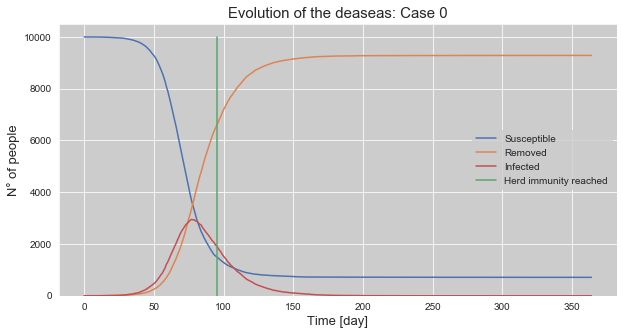

In [ ]:
#plotting S(t), I(t) and R(t)
pal = sns.color_palette("deep")
pal.as_hex()
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(range(365), S_t, label='Susceptible', color= pal[0]) 
ax.plot(range(365), R_t, label='Removed', color=pal[1]) 
ax.plot(range(365), I_t, label='Infected', color = pal[3]) 
ax.plot([day_end, day_end], [0, N], label = "Herd immunity reached", color = pal[2])

ax.set_ylim(ymin=0)
ax.set_xlabel("Time [day]", fontsize=13)
ax.set_ylabel("N° of people", fontsize=13) 
ax.legend()
plt.title(f"Evolution of the deaseas: Case 0", fontsize=15)
plt.show()

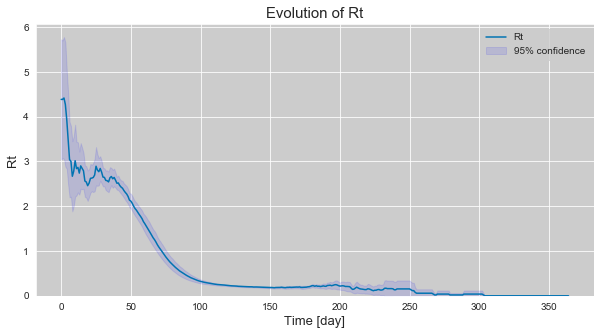

In [ ]:
#plotting Rt + confidence interval
sns.set_palette("colorblind")  
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})
fig, ax = plt.subplots(figsize=(10,5))

RT = np.array(RT)
Mean_rt = []
CI_rt = []
for i in range(365):
  ci_rt, m_rt = conf_int(RT[:,i], cl, len(RT))
  Mean_rt.append(m_rt)
  CI_rt.append(ci_rt)

LW_ci = []
UP_ci = []
for i in range(len(CI_rt)):
  LW_ci.append(CI_rt[i][0])
  UP_ci.append(CI_rt[i][1])

ax.plot(range(365), Mean_rt, label='Rt') 
ax.fill_between(range(365), LW_ci, UP_ci, color='b', alpha=.1, label="95% confidence")
ax.set_ylim(ymin=0)
ax.set_xlabel("Time [day]", fontsize=13)
ax.set_ylabel("Rt", fontsize=13) 
ax.legend()
plt.title("Evolution of Rt", fontsize=15)
plt.show()

###Case 1

In [ ]:
#input variable
N_runs = 30
cl = 0.95
seed = 1

days = 365
N = 10000
beta = [0.25, 0.125, 0.125, 0.125, 0.125]
gamma = [1/12, 1/14, 1/16]
N_location = len(beta) 
P_out = 0.8

print(f"The population size is: {N}")
print(f"\u03B2 = {beta}")
print(f"\u03B3 = {gamma}")

The population size is: 10000
β = [0.25, 0.125, 0.125, 0.125, 0.125]
γ = [0.08333333333333333, 0.07142857142857142, 0.0625]


In [ ]:
#output metrics
I_max = []
I_max_day = []
Days_end = []
RT = []

In [ ]:
#simulation
for r in range(N_runs):
  print(f"Run: {r}")
  np.random.seed(seed)
  random.seed(seed)
  i_max, day_max, day_end, Rt = Simulate(days, N, beta, gamma, N_location, P_out)
  I_max.append(i_max)
  I_max_day.append(day_max)
  Days_end.append(day_end)
  RT.append(Rt)
  seed += 1

Run: 0
Run: 1
Run: 2
Run: 3
Run: 4
Run: 5
Run: 6
Run: 7
Run: 8
Run: 9
Run: 10
Run: 11
Run: 12
Run: 13
Run: 14
Run: 15
Run: 16
Run: 17
Run: 18
Run: 19
Run: 20
Run: 21
Run: 22
Run: 23
Run: 24
Run: 25
Run: 26
Run: 27
Run: 28
Run: 29


In [ ]:
ci_max, mean_max = conf_int(I_max, cl, len(I_max))
ci_max_day, mean_max_day = conf_int(I_max_day, cl, len(I_max_day)) 
ci_end, mean_end = conf_int(Days_end, cl, len(Days_end)) 

print("With degenerative runs")
print(f'The maximum number of infected people is {mean_max}')
print(f'With the confidence interval: {ci_max}')
print(f'The maximum number of infected people is reached after {mean_max_day} day')
print(f'With the confidence interval: {ci_max_day}')
print(f'The epidemics end after {mean_end} days')
print(f'With the confidence interval: {ci_end}')

With degenerative runs
The maximum number of infected people is 2232.266666666667
With the confidence interval: (1587.1880871868761, 2877.3452461464576)
The maximum number of infected people is reached after 43.6 day
With the confidence interval: (31.504789063243408, 55.695210936756595)
The epidemics end after 54.166666666666664 days
With the confidence interval: (40.61926966501783, 67.7140636683155)


In [ ]:
#remove the degenerative runs
deg = 0
for i in reversed(range(N_runs)): 
  if I_max[i] < 50:
    I_max.pop(i)
    I_max_day.pop(i)
    Days_end.pop(i)
    RT.pop(i)
    deg += 1

print(f"degenerative runs removed: {deg}")

ci_max, mean_max = conf_int(I_max, cl, len(I_max))
ci_max_day, mean_max_day = conf_int(I_max_day, cl, len(I_max_day)) 
ci_end, mean_end = conf_int(Days_end, cl, len(Days_end)) 

print("Without degenerative runs")
print(f'The maximum number of infected people is {mean_max}')
print(f'With the confidence interval: {ci_max}')
print(f'The maximum number of infected people is reached after {mean_max_day} day')
print(f'With the confidence interval: {ci_max_day}')
print(f'The epidemics end after {mean_end} days')
print(f'With the confidence interval: {ci_end}')

degenerative runs removed: 11
Without degenerative runs
The maximum number of infected people is 3523.7894736842104
With the confidence interval: (3485.3804208613415, 3562.1985265070794)
The maximum number of infected people is reached after 66.89473684210526 day
With the confidence interval: (61.76891725425998, 72.02055642995053)
The epidemics end after 80.3157894736842 days
With the confidence interval: (75.30157283152585, 85.33000611584256)


In [ ]:
np.random.seed(1)
random.seed(1) 
environment = Environment(N, beta, gamma, N_location, P_out) 
S_t = []
I_t = []
R_t = []
for _ in range(days):
  environment.move()
  environment.infect()
  environment.recover()
  environment.next_day()
  S_n, I_n, R_n = environment.get_SIR()
  S_t.append(S_n)
  I_t.append(I_n)
  R_t.append(R_n)

print(f"Max infected: {np.max(I_t)}")
print(f"Day max: {np.argmax(I_t)+1}")
day_end = find_herd_immunity(R_t, N_imm)
print(f"Day end: {day_end}")

Max infected: 3377
Day max: 73
Day end = 85


### Plotting case 1

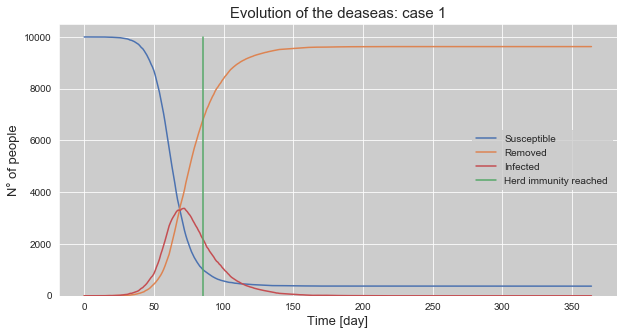

In [ ]:
#plotting S(t), I(t) and R(t)
pal = sns.color_palette("deep")
pal.as_hex()
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(range(365), S_t, label='Susceptible', color= pal[0]) 
ax.plot(range(365), R_t, label='Removed', color=pal[1]) 
ax.plot(range(365), I_t, label='Infected', color = pal[3]) 
ax.plot([day_end, day_end], [0, N], label = "Herd immunity reached", color = pal[2])

ax.set_ylim(ymin=0)
ax.set_xlabel("Time [day]", fontsize=13)
ax.set_ylabel("N° of people", fontsize=13) 
ax.legend()
plt.title(f"Evolution of the deaseas: case 1", fontsize=15)
plt.show()

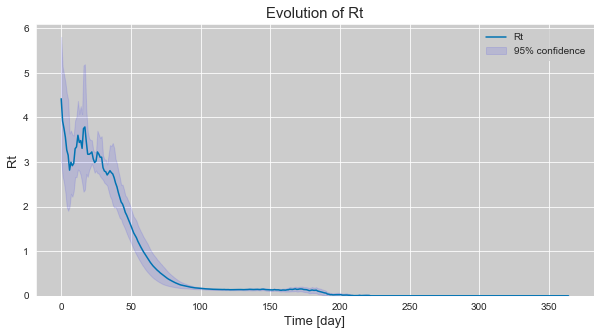

In [ ]:
#plotting Rt + confidence interval
sns.set_palette("colorblind")  
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})
fig, ax = plt.subplots(figsize=(10,5))

RT = np.array(RT)
Mean_rt = []
CI_rt = []
for i in range(365):
  ci_rt, m_rt = conf_int(RT[:,i], cl, len(RT))
  Mean_rt.append(m_rt)
  CI_rt.append(ci_rt)

LW_ci = []
UP_ci = []
for i in range(len(CI_rt)):
  LW_ci.append(CI_rt[i][0])
  UP_ci.append(CI_rt[i][1])

ax.plot(range(365), Mean_rt, label='Rt') 
ax.fill_between(range(365), LW_ci, UP_ci, color='b', alpha=.1, label="95% confidence")
ax.set_ylim(ymin=0)
ax.set_xlabel("Time [day]", fontsize=13)
ax.set_ylabel("Rt", fontsize=13) 
ax.legend()
plt.title("Evolution of Rt", fontsize=15)
plt.show()

###Case 2

In [ ]:
def Simulate(days, N, beta, gamma, N_location, P_out, limit):
  environment = Environment(N, beta, gamma, N_location, P_out)
  I_t = []
  R_t = []
  N_imm = 6428
  for _ in range(days):
    environment.move()
    environment.infect()
    environment.recover()
    environment.next_day()
    _ , I, R = environment.get_SIR()
    if I >= limit:
      environment.set_restriction(new_P_out = 0.5)
    I_t.append(I)
    R_t.append(R)
    
  i_max = np.max(I_t)
  day_max = np.argmax(I_t)+1 
  day_end = find_herd_immunity(R_t, N_imm)
  Rt = compute_Rt(environment)
  return i_max, day_max, day_end, Rt

In [ ]:
#input variable
N_runs = 30
cl = 0.95
seed = 1

days = 365
N = 10000
beta = [0.125, 0.125, 0.125, 0.125, 0.125]
gamma = [1/12, 1/14, 1/16]
N_location = len(beta) 
P_out = 0.8
limit = 1000

print(f"The population size is: {N}")
print(f"\u03B2 = {beta}")
print(f"\u03B3 = {gamma}")

The population size is: 10000
β = [0.125, 0.125, 0.125, 0.125, 0.125]
γ = [0.08333333333333333, 0.07142857142857142, 0.0625]


In [ ]:
#output metrics
I_max = []
I_max_day = []
Days_end = []
RT = []

In [ ]:
#simulation
for r in range(N_runs):
  print(f"Run: {r}")
  np.random.seed(seed)
  random.seed(seed)
  i_max, day_max, day_end, Rt = Simulate(days, N, beta, gamma, N_location, P_out, limit)
  I_max.append(i_max)
  I_max_day.append(day_max)
  Days_end.append(day_end)
  RT.append(Rt)
  seed += 1

Run: 0
Run: 1
Run: 2
Run: 3
Run: 4
Run: 5
Run: 6
Run: 7
Run: 8
Run: 9
Run: 10
Run: 11
Run: 12
Run: 13
Run: 14
Run: 15
Run: 16
Run: 17
Run: 18
Run: 19
Run: 20
Run: 21
Run: 22
Run: 23
Run: 24
Run: 25
Run: 26
Run: 27
Run: 28
Run: 29


In [ ]:
ci_max, mean_max = conf_int(I_max, cl, len(I_max))
ci_max_day, mean_max_day = conf_int(I_max_day, cl, len(I_max_day)) 
ci_end, mean_end = conf_int(Days_end, cl, len(Days_end)) 

print("With degenerative runs")
print(f'The maximum number of infected people is {mean_max}')
print(f'With the confidence interval: {ci_max}')
print(f'The maximum number of infected people is reached after {mean_max_day} day')
print(f'With the confidence interval: {ci_max_day}')
print(f'The epidemics end after {mean_end} days')
print(f'With the confidence interval: {ci_end}')

With degenerative runs
The maximum number of infected people is 1402.5
With the confidence interval: (1192.4151223645933, 1612.5848776354067)
The maximum number of infected people is reached after 73.1 day
With the confidence interval: (62.127935789488376, 84.07206421051161)
The epidemics end after 111.73333333333333 days
With the confidence interval: (95.82323583253874, 127.64343083412793)


In [ ]:
#remove the degenerative runs
deg = 0
for i in reversed(range(N_runs)): 
  if I_max[i] < 50:
    I_max.pop(i)
    I_max_day.pop(i)
    Days_end.pop(i)
    RT.pop(i)
    deg += 1

print(f"degenerative runs removed: {deg}")

ci_max, mean_max = conf_int(I_max, cl, len(I_max))
ci_max_day, mean_max_day = conf_int(I_max_day, cl, len(I_max_day)) 
ci_end, mean_end = conf_int(Days_end, cl, len(Days_end)) 

print("Without degenerative runs")
print(f'The maximum number of infected people is {mean_max}')
print(f'With the confidence interval: {ci_max}')
print(f'The maximum number of infected people is reached after {mean_max_day} day')
print(f'With the confidence interval: {ci_max_day}')
print(f'The epidemics end after {mean_end} days')
print(f'With the confidence interval: {ci_end}')

degenerative runs removed: 4
Without degenerative runs
The maximum number of infected people is 1618.0384615384614
With the confidence interval: (1589.9925367862904, 1646.0843862906324)
The maximum number of infected people is reached after 83.92307692307692 day
With the confidence interval: (80.16881424231319, 87.67733960384065)
The epidemics end after 127.84615384615384 days
With the confidence interval: (124.29232187640238, 131.3999858159053)


In [ ]:
np.random.seed(1)
random.seed(1) 
environment = Environment(N, beta, gamma, N_location, P_out) 
S_t = []
I_t = []
R_t = []
day_lock = 0
for day in range(days):
  environment.move()
  environment.infect()
  environment.recover()
  environment.next_day()
  S_n, I_n, R_n = environment.get_SIR()
  if I_n >= limit and day_lock == 0:
    environment.set_restriction(new_P_out = 0.5)
    day_lock = day+1
  S_t.append(S_n)
  I_t.append(I_n)
  R_t.append(R_n)

print(f"Max infected: {np.max(I_t)}")
print(f"Day max: {np.argmax(I_t)+1}")
day_end = find_herd_immunity(R_t, N_imm)
print(f"Day end: {day_end}")
print(f"Day lock down: {day_lock}")

Max infected: 1649
Day max: 78
Day end: 129
Day lock down: 59


### Plotting case 2

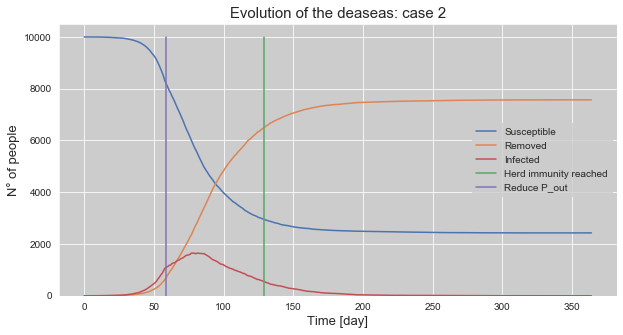

In [ ]:
#plotting S(t), I(t) and R(t)
pal = sns.color_palette("deep")
pal.as_hex()
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(range(365), S_t, label='Susceptible', color= pal[0]) 
ax.plot(range(365), R_t, label='Removed', color=pal[1]) 
ax.plot(range(365), I_t, label='Infected', color = pal[3]) 
ax.plot([day_end, day_end], [0, N], label = "Herd immunity reached", color = pal[2])
ax.plot([day_lock, day_lock], [0, N], label = "Reduce P_out", color = pal[4])
ax.set_ylim(ymin=0)
ax.set_xlabel("Time [day]", fontsize=13)
ax.set_ylabel("N° of people", fontsize=13) 
ax.legend()
plt.title(f"Evolution of the deaseas: case 2", fontsize=15)
plt.show()

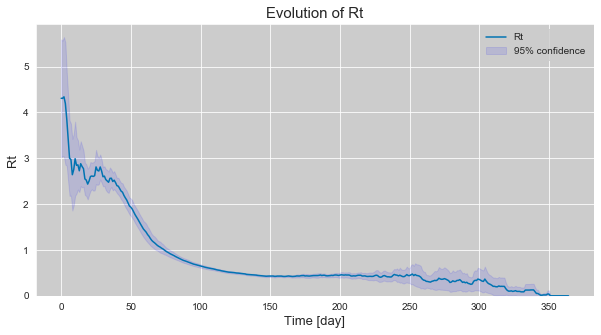

In [ ]:
#plotting Rt + confidence interval
sns.set_palette("colorblind")  
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})
fig, ax = plt.subplots(figsize=(10,5))

RT = np.array(RT)
Mean_rt = []
CI_rt = []
for i in range(365):
  ci_rt, m_rt = conf_int(RT[:,i], cl, len(RT))
  Mean_rt.append(m_rt)
  CI_rt.append(ci_rt)

LW_ci = []
UP_ci = []
for i in range(len(CI_rt)):
  LW_ci.append(CI_rt[i][0])
  UP_ci.append(CI_rt[i][1])

ax.plot(range(365), Mean_rt, label='Rt') 
ax.fill_between(range(365), LW_ci, UP_ci, color='b', alpha=.1, label="95% confidence")
ax.set_ylim(ymin=0)
ax.set_xlabel("Time [day]", fontsize=13)
ax.set_ylabel("Rt", fontsize=13) 
ax.legend()
plt.title("Evolution of Rt", fontsize=15)
plt.show()